In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import pyprojroot
import scipy.stats
from scipy.optimize import curve_fit
import seaborn as sns
import statsmodels.api

from patsy import dmatrices

* Make new 'feature' visual search stimuli datasets with differing discriminability of target and distractors
  > 'Feature' search is red vertical rectangle target v. green vertical rectangle distractors.
Here the red and green are both moved closer to yellow, e.g. for the value of 51 the "red" target's RGB color is `[255 51 0]` while the "green" distractor is `[51 255 0]`. Since `[255 255 0]` is yellow, both the target and distractor colors are being shifted closer to yellow, but from opposite directions.

* Use new datasets with different target-distractor discriminabilities to get accuracy of neural networks previously trained on this 'feature' visual search task

In [2]:
D_RANGE = np.linspace(0,1,1000)

In [3]:
par0 = np.asarray([0., 1.])

def psychometric_func(x, alpha, beta):
    """psychometric function"""
    return 1. / (1 + np.exp( -(x - alpha) / beta) )

def fits_df_from_discrim_df(discrim_df,
                            d_range=D_RANGE,
                            threshold_acc=0.75):
    records = []  # list of dict we will convert to a pandas.DataFrame

    for net_name in discrim_df.net_name.unique():
        for method_source_dataset in discrim_df.method_source_dataset.unique():
            this_df = discrim_df[
                (discrim_df.net_name == net_name) &
                (discrim_df.method_source_dataset == method_source_dataset)
            ]
            for subject in this_df.net_number.unique():
                df_subject = this_df[this_df.net_number == subject]

                for set_size in df_subject.set_size.unique():
                    df_set_size = df_subject[df_subject.set_size == set_size]
                    df_set_size = df_set_size.sort_values(by='discrim_pct')
                    discrim_pct = df_set_size.discrim_pct.values
                    acc = df_set_size.accuracy.values

                    popt, pcov = curve_fit(psychometric_func, discrim_pct, acc, par0)
                    params_cov = np.diag(pcov)

                    y = psychometric_func(d_range, popt[0], popt[1])
                    # where (on x-axis) did subject have threshold performance for this set size?
                    th_ind = np.argmin(np.abs(y - threshold_acc))
                    discrim_threshold = d_range[th_ind]

                    records.append(
                        {
                            'net_name': net_name,
                            'method': this_df.method.unique()[0],
                            'source_dataset': this_df.source_dataset.unique()[0],
                            'net_number': subject,
                            'set_size': set_size,
                            'alpha': popt[0],
                            'alpha_cov': params_cov[0],
                            'beta': popt[1],
                            'beta_cov': params_cov[1],
                            'threshold_acc': threshold_acc,
                            'discrim_threshold': discrim_threshold,
                        }
                    )

    fits_df = pd.DataFrame.from_records(records)
    return fits_df

In [4]:
def inspect_fits(fits_source_df,
                 fits_df,
                 net_name,
                 method,
                 source_dataset,
                 d_range=D_RANGE,
                ):
    this_fits_source_df = fits_source_df[
        (fits_source_df.net_name == net_name) &
        (fits_source_df.method == method) & 
        (fits_source_df.source_dataset == source_dataset)       
    ]
    this_fits_df = fits_df[
        (fits_df.net_name == net_name) &
        (fits_df.method == method) & 
        (fits_df.source_dataset == source_dataset)
    ]
    
    fig, ax = plt.subplots(2, 2)
    fig.set_size_inches(10,10)
    ax = ax.ravel()

    for set_size_ind, set_size in enumerate(this_fits_df.set_size.unique()):
        source_set_size_df = this_fits_source_df[
            this_fits_source_df.set_size == set_size
        ]
        fits_set_size_df = this_fits_df[
            this_fits_df.set_size == set_size
        ]

        for net_number_ind, net_number in enumerate(source_set_size_df.net_number.unique()):
            source_net_num_df = source_set_size_df[
                source_set_size_df.net_number == net_number
            ]
            fits_net_num_df = fits_set_size_df[
                fits_set_size_df.net_number == net_number
            ]
            
            discrim_pct = source_net_num_df.discrim_pct.values
            acc = source_net_num_df.accuracy.values
            ax[set_size_ind].plot(discrim_pct, acc, marker='o', linestyle='None')

            ax[set_size_ind].plot(fits_net_num_df['discrim_threshold'], 
                                  fits_net_num_df['threshold_acc'], 
                                  marker='x',
                                  linestyle='None')
            
            ax[set_size_ind].plot(d_range, 
                                  psychometric_func(d_range, 
                                                    fits_net_num_df.alpha.values.item(),
                                                    fits_net_num_df.beta.values.item()))

        ax[set_size_ind].set_title(f"set size: {set_size}")
        ax[set_size_ind].set_xlabel('target-distractor\ndiscriminability (%)')
        ax[set_size_ind].set_ylabel('accuracy')
        ax[set_size_ind].set_ylim([0.0, 1.0])

    fig.tight_layout()

## Munge test accuracy data

In [5]:
SOURCE_DATASETS_TO_USE = (
    'ImageNet',
    'Stylized ImageNet',
    'DomainNet, Clipart domain',
)

In [6]:
results_csv = pyprojroot.here() / 'results' / 'searchstims' / 'source_data' / 'discriminability' / 'all.csv'
df = pd.read_csv(results_csv)
df = df[df.target_condition == 'both']  # note that we keep only 'both' condition!
df = df[df.source_dataset.isin(SOURCE_DATASETS_TO_USE)]  # do *not* keep random weights, and training just on `searchstims` themselves

# factorize method + source dataset, to iterate over in slightly more concise way
df['method_source_dataset'] = pd.factorize(pd._lib.fast_zip(
    [df.method.values, df.source_dataset.values]
))[0]

In [7]:
df_rvg = df[df['stimulus'].str.contains('RVvGV')].copy()
df_rvg['yellowness'] = df_rvg['stimulus'].apply(lambda x: int(x.split('_')[-1]))
df_rvg['discrim_pct'] = 1 - (df_rvg.yellowness / 255.)

In [8]:
df_tvt = df[df['stimulus'].str.contains('TvT')].copy()
df_tvt['rotation'] = df_tvt['stimulus'].apply(lambda x: int(x.split('_')[-1]))
df_tvt['discrim_pct'] = df_tvt.rotation / 90.

## Fit a psychometric function

In [9]:
fits_rvg_df = fits_df_from_discrim_df(df_rvg)

/home/bart/.cache/pypoetry/virtualenvs/nicholson-prinz-2021-zheWulbu-py3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [10]:
fits_tvt_df = fits_df_from_discrim_df(df_tvt)

## Do a sanity check; what do the fits look like?

In [11]:
mpl.style.use('bmh')

# plt.rcParams['font.size'] = 18
# plt.rcParams['axes.labelsize'] = 18
# plt.rcParams['axes.labelweight'] = 'regular'
# plt.rcParams['axes.titlesize'] = 20
# plt.rcParams['xtick.labelsize'] = 16
# plt.rcParams['ytick.labelsize'] = 16
# plt.rcParams['legend.fontsize'] = 16
# plt.rcParams['figure.titlesize'] = 20

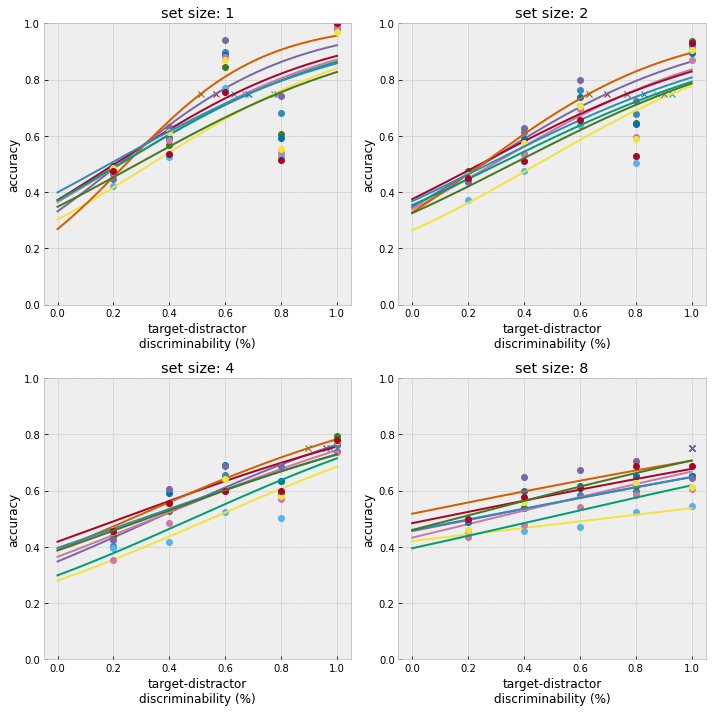

In [12]:
inspect_fits(fits_source_df=df_tvt,
             fits_df=fits_tvt_df,
             net_name='alexnet',
             method='transfer',
             source_dataset='ImageNet',
                )

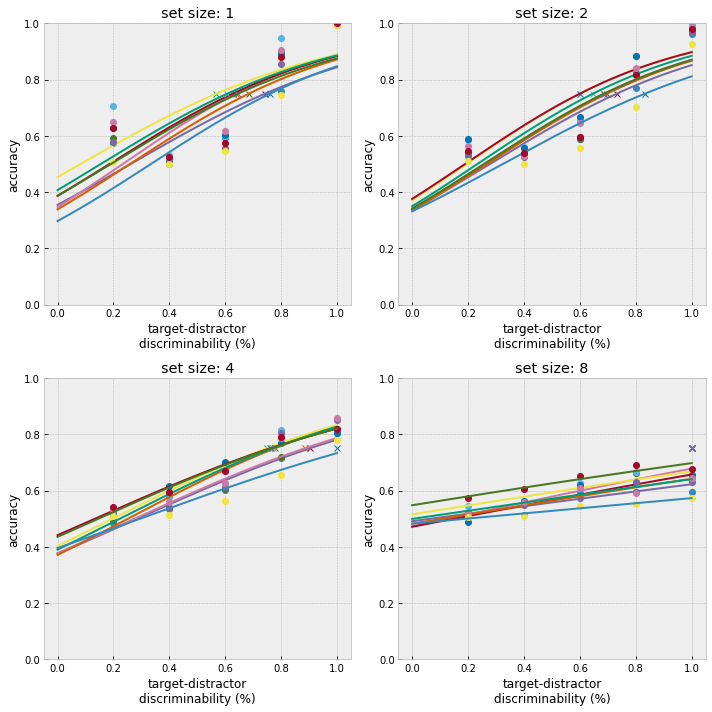

In [13]:
inspect_fits(fits_source_df=df_tvt,
             fits_df=fits_tvt_df,
             net_name='alexnet',
             method='transfer',
             source_dataset='Stylized ImageNet',
                )

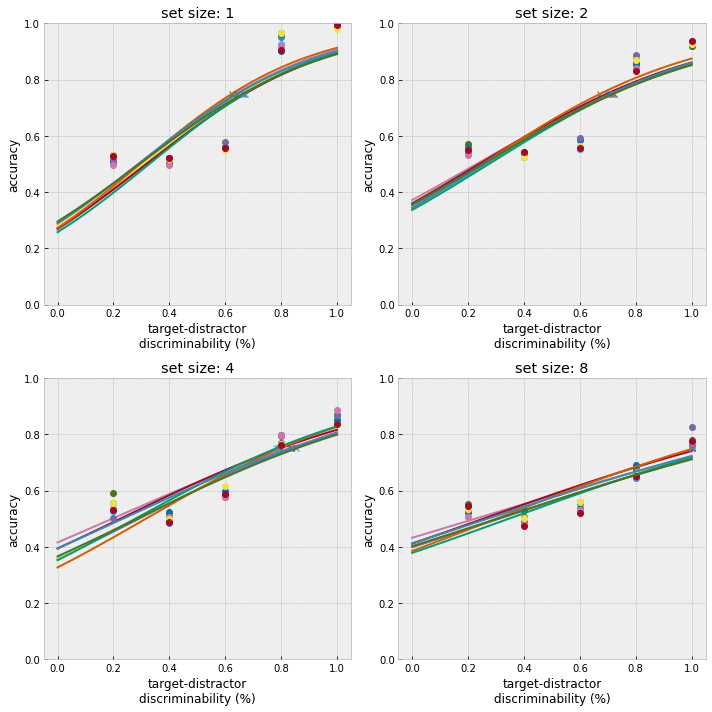

In [14]:
inspect_fits(fits_source_df=df_tvt,
             fits_df=fits_tvt_df,
             net_name='alexnet',
             method='transfer',
             source_dataset='DomainNet, Clipart domain',
                )

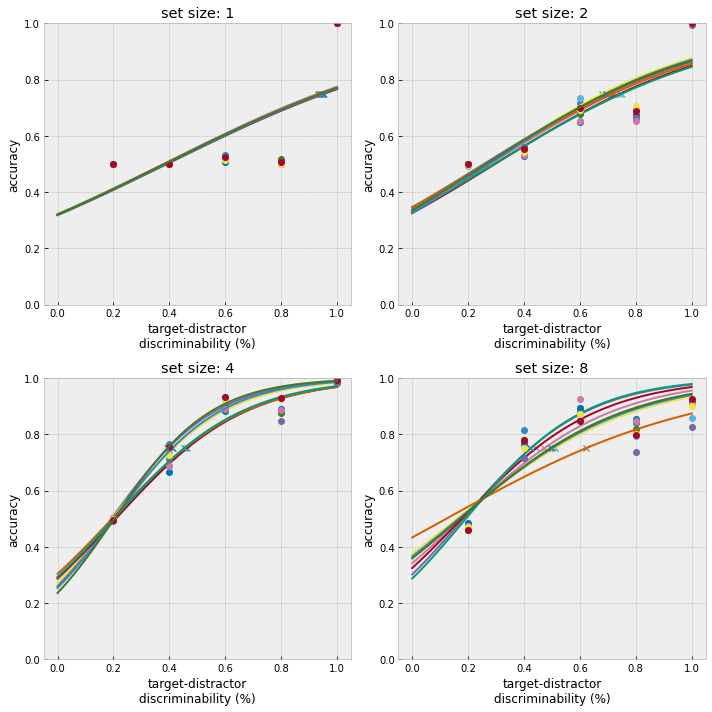

In [15]:
inspect_fits(fits_source_df=df_tvt,
             fits_df=fits_tvt_df,
             net_name='VGG16',
             method='transfer',
             source_dataset='Stylized ImageNet',
                )

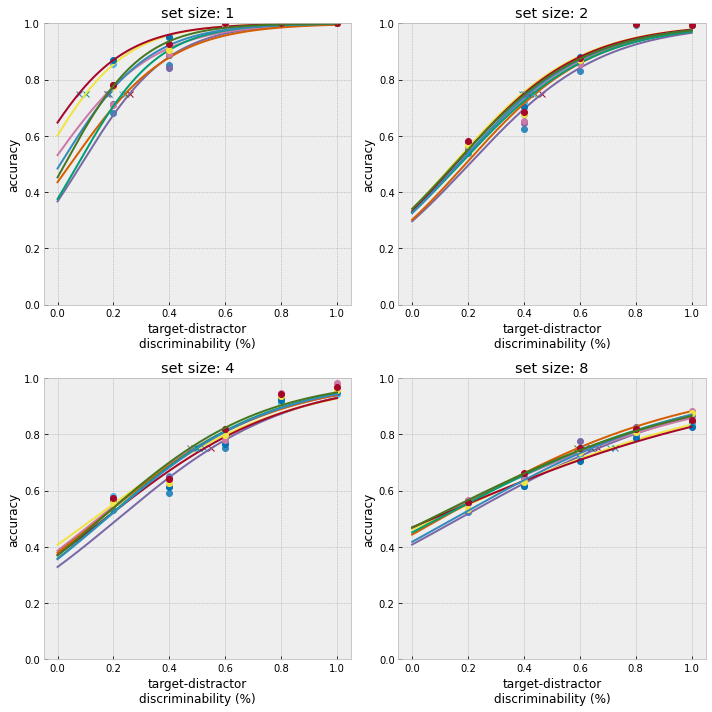

In [16]:
inspect_fits(fits_source_df=df_tvt,
             fits_df=fits_tvt_df,
             net_name='VGG16',
             method='transfer',
             source_dataset='DomainNet, Clipart domain',
                )

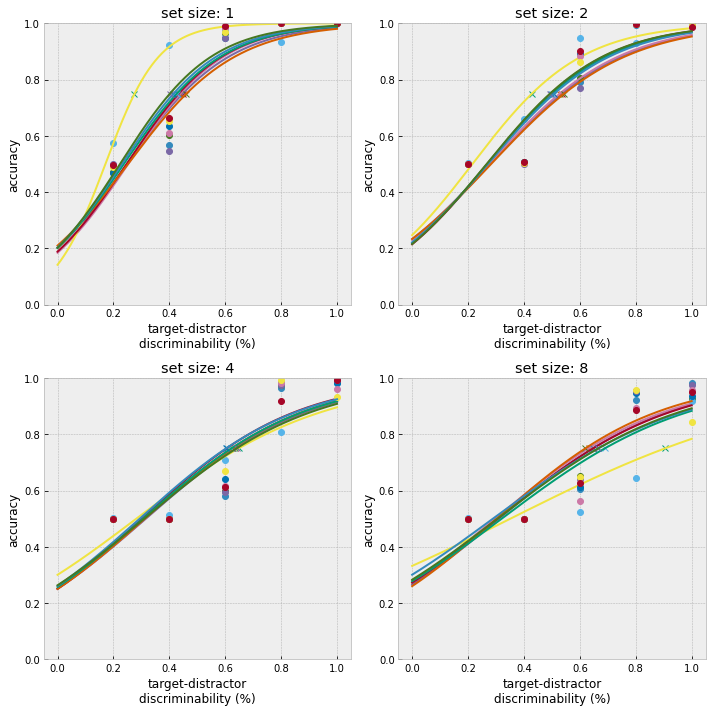

In [17]:
inspect_fits(fits_source_df=df_rvg,
             fits_df=fits_rvg_df,
             net_name='alexnet',
             method='transfer',
             source_dataset='ImageNet',
                )

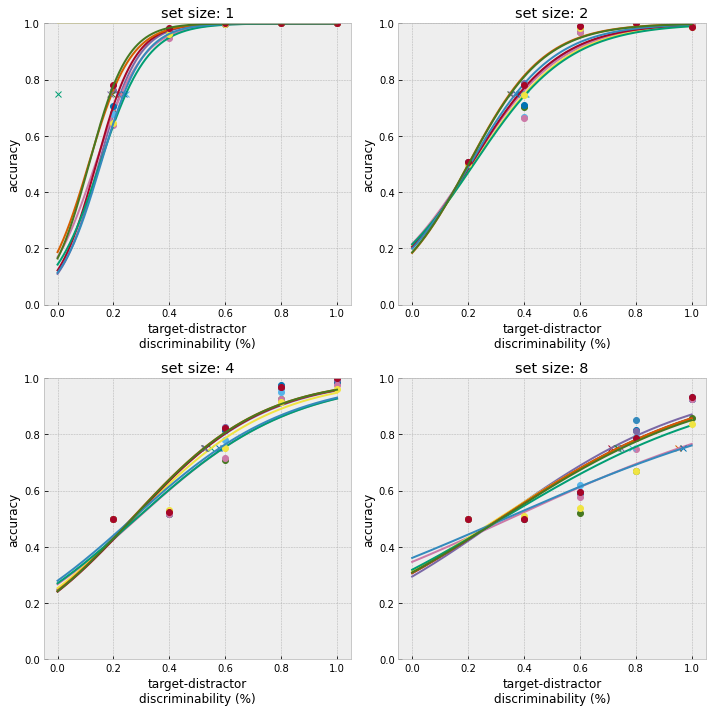

In [18]:
inspect_fits(fits_source_df=df_rvg,
             fits_df=fits_rvg_df,
             net_name='alexnet',
             method='transfer',
             source_dataset='Stylized ImageNet',
                )

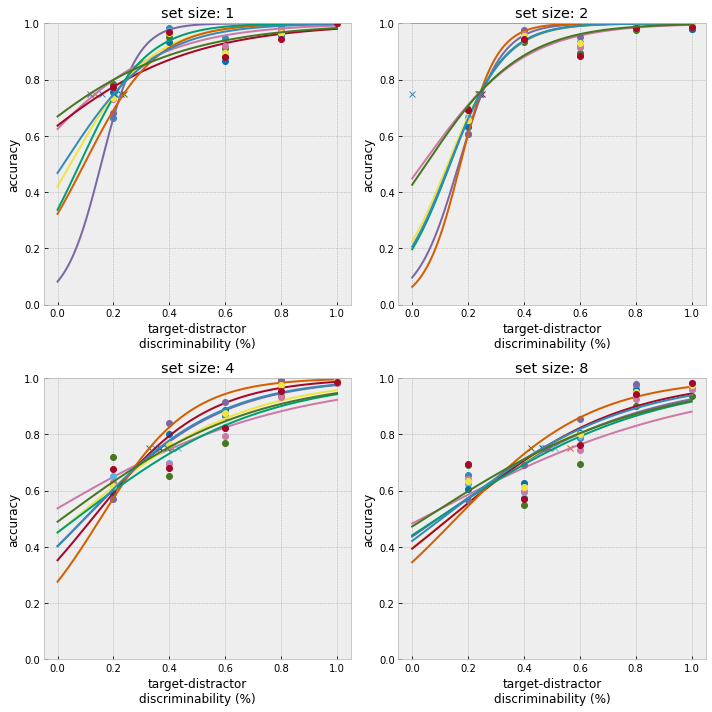

In [19]:
inspect_fits(fits_source_df=df_rvg,
             fits_df=fits_rvg_df,
             net_name='alexnet',
             method='transfer',
             source_dataset='DomainNet, Clipart domain',
                )

## Use the fit parameters to find the desired difference threshold, i.e. what target-distractor discriminability gives us a difference threshold of X?
Here the threshold was 75%, following Palmer et al. 2000 and references therein (https://www.sciencedirect.com/science/article/pii/S0042698999002448)

In [20]:
fits_rvg_df['log_set_size'] = np.log10(fits_rvg_df.set_size)
fits_rvg_df['log_discrim_threshold'] = np.log10(fits_rvg_df.discrim_threshold)

/home/bart/.cache/pypoetry/virtualenvs/nicholson-prinz-2021-zheWulbu-py3.7/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [21]:
fits_tvt_df['log_set_size'] = np.log10(fits_tvt_df.set_size)
fits_tvt_df['log_discrim_threshold'] = np.log10(fits_tvt_df.discrim_threshold)

### find slopes for plotting

In [63]:
slopes_tvt_records = []

for net_name in fits_tvt_df.net_name.unique():
    for method in fits_tvt_df.method.unique():
        for source_dataset in fits_tvt_df.source_dataset.unique():
            this_fits_df = fits_tvt_df[
                (fits_tvt_df.net_name == net_name) & 
                (fits_tvt_df.method == method) & 
                (fits_tvt_df.source_dataset == source_dataset)
            ]
            if len(this_fits_df) == 0:
                continue
            for net_number in this_fits_df.net_number.unique():
                netnum_df = this_fits_df[this_fits_df.net_number == net_number]
                x, y = netnum_df.log_set_size.values, netnum_df.log_discrim_threshold.values
                result = scipy.stats.linregress(x, y)
                record = {
                    'net_name': net_name,
                    'method': method,
                    'source_dataset': source_dataset,
                    'net_number': net_number,
                    'intercept': result.intercept,
                    'intercept_stderr': result.intercept_stderr,
                    'pvalue': result.pvalue,
                    'rvalue': result.rvalue,
                    'slope': result.slope,
                    'stderr': result.stderr,
                }
                slopes_tvt_records.append(record)

In [7]:
## Log transform, then find mean difference threshold across 'subjects' (training replicates) so we can do linear regression on set size v. difference threshold

### statistical test

In [22]:
y_tvt, X_tvt = dmatrices('log_discrim_threshold ~ log_set_size + source_dataset + net_name', 
                         data=fits_tvt_df, 
                         return_type='dataframe')
mod_tvt = statsmodels.api.OLS(y_tvt, X_tvt)
res_tvt = mod_tvt.fit()
print(res_tvt.summary())

                              OLS Regression Results                             
Dep. Variable:     log_discrim_threshold   R-squared:                       0.447
Model:                               OLS   Adj. R-squared:                  0.435
Method:                    Least Squares   F-statistic:                     37.80
Date:                   Mon, 19 Jul 2021   Prob (F-statistic):           3.74e-23
Time:                           17:24:23   Log-Likelihood:                 120.58
No. Observations:                    192   AIC:                            -231.2
Df Residuals:                        187   BIC:                            -214.9
Df Model:                              4                                         
Covariance Type:               nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

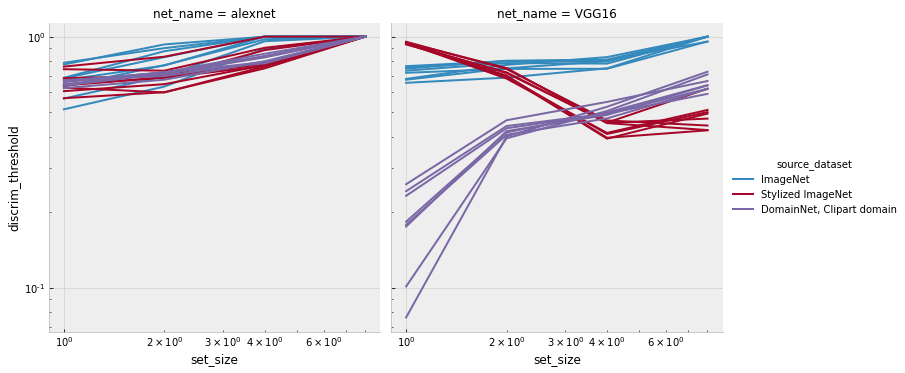

In [23]:
g = sns.relplot(
    x='set_size',
    y='discrim_threshold',
    data=fits_tvt_df,
    hue='source_dataset',
    col='net_name',
    kind='line',
    units='net_number',
    estimator=None,
)

for ax_ in g.axes.ravel():
    ax_.set_xscale("log")
    ax_.set_yscale("log")

In [24]:
y_rvg, X_rvg = dmatrices('log_discrim_threshold ~ log_set_size + source_dataset + net_name', 
                         data=fits_rvg_df, 
                         return_type='dataframe')
mod_rvg = statsmodels.api.OLS(y_rvg, X_rvg)
res_rvg = mod_rvg.fit()
print(res_rvg.summary())

                              OLS Regression Results                             
Dep. Variable:     log_discrim_threshold   R-squared:                         nan
Model:                               OLS   Adj. R-squared:                    nan
Method:                    Least Squares   F-statistic:                       nan
Date:                   Mon, 19 Jul 2021   Prob (F-statistic):                nan
Time:                           17:24:29   Log-Likelihood:                    nan
No. Observations:                    192   AIC:                               nan
Df Residuals:                        187   BIC:                               nan
Df Model:                              4                                         
Covariance Type:               nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

/home/bart/.cache/pypoetry/virtualenvs/nicholson-prinz-2021-zheWulbu-py3.7/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1666: RuntimeWarning: invalid value encountered in subtract
  return np.sum(weights * (model.endog - mean)**2)


In [38]:
def regress_net_number(fits_df):
    """do regression to get a slope for each "subject", i.e. training replicate, 'net_number'
    from a DataFrame
    """
    slopes_records = []

    for net_name in fits_df.net_name.unique():
        for method in fits_df.method.unique():
            for source_dataset in fits_df.source_dataset.unique():
                this_fits_df = fits_df[
                    (fits_df.net_name == net_name) & 
                    (fits_df.method == method) & 
                    (fits_df.source_dataset == source_dataset)
                ]
                if len(this_fits_df) == 0:
                    continue
                for net_number in this_fits_df.net_number.unique():
                    netnum_df = this_fits_df[this_fits_df.net_number == net_number]
                    x, y = netnum_df.log_set_size.values, netnum_df.log_discrim_threshold.values
                    result = scipy.stats.linregress(x, y)
                    record = {
                        'net_name': net_name,
                        'method': method,
                        'source_dataset': source_dataset,
                        'net_number': net_number,
                        'intercept': result.intercept,
                        'intercept_stderr': result.intercept_stderr,
                        'pvalue': result.pvalue,
                        'rvalue': result.rvalue,
                        'slope': result.slope,
                        'stderr': result.stderr,
                    }
                    slopes_records.append(record)
        
    slopes_df = pd.DataFrame.from_records(slopes_records)
    return slopes_df

In [39]:
slopes_df = regress_net_number(fits_rvg_df)
slopes_df = slopes_df.dropna()
slopes_df_gb = slopes_df.groupby(by=['net_name', 'source_dataset']).agg(
    slope = pd.NamedAgg('slope', aggfunc='mean'),
    intercept = pd.NamedAgg('intercept', aggfunc='mean')
)


/home/bart/.cache/pypoetry/virtualenvs/nicholson-prinz-2021-zheWulbu-py3.7/lib/python3.7/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


In [41]:
slopes_agg_df = slopes_df_gb.reset_index()
slopes_agg_df = slopes_agg_df.sort_values(by=['net_name', 'slope'])

,net_name,source_dataset,slope,intercept
2,VGG16,Stylized ImageNet,0.176232,-0.354506
1,VGG16,ImageNet,0.421460,-0.375551
0,VGG16,"DomainNet, Clipart domain",0.722646,-0.936205
4,alexnet,ImageNet,0.252309,-0.378929
3,alexnet,"DomainNet, Clipart domain",0.484554,-0.739351
5,alexnet,Stylized ImageNet,0.616812,-0.638677


In [88]:
palette = {
    'ImageNet': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961), 
    'Stylized ImageNet': (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
    'DomainNet, Clipart domain': (0.6509803921568628, 0.8470588235294118, 0.32941176470588235)
}

In [95]:
sns.set()

In [101]:
import matplotlib

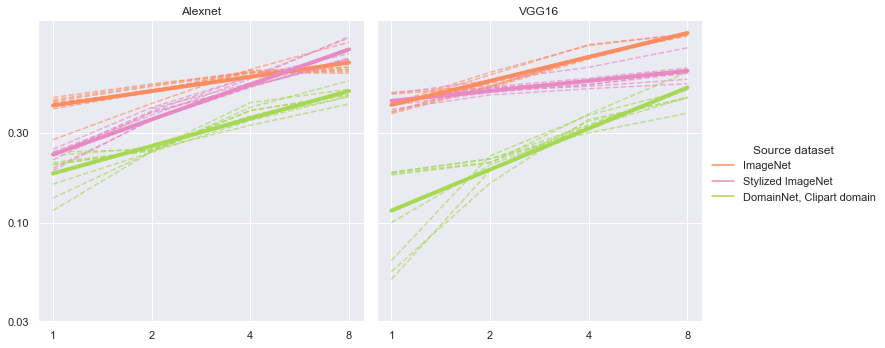

In [117]:

g = sns.relplot(
    x='set_size',
    y='discrim_threshold',
    data=fits_rvg_df[fits_rvg_df.discrim_threshold != 0.0],
    hue='source_dataset',
    col='net_name',
    kind='line',
    units='net_number',
    estimator=None,
    alpha=0.65,
    linestyle='--',
    palette=palette
)

def line(x, m, b):
    return m * np.log10(x) + b

x = np.linspace(1, 8, 1000)
for row in slopes_agg_df.itertuples():
    m, b = row.slope, row.intercept
    y = line(x, m, b)
    y = 10 ** y
    if row.net_name == 'alexnet':
        ax = g.fig.axes[0]
    else:
        ax = g.fig.axes[1]
    color = palette[row.source_dataset]
    ax.plot(x, y, c=color, linewidth=4)

for ax_, net_name in zip(g.fig.axes, ('Alexnet', 'VGG16')):
    ax_.set_xscale('log')
    ax_.set_xticks([1, 2, 4, 8])
    ax_.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax_.get_xaxis().set_minor_formatter('')
    ax_.set_yscale('log')
    ax_.set_yticks([0.03, 0.1, 0.3])
    ax_.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax_.set_title(net_name)
    ax_.set_xlabel('')
    ax_.set_ylabel('')

g._legend.set_title("Source dataset")

for ext in ('svg', 'png'):
    g.fig.savefig(
        pyprojroot.here() / f'docs/paper/figures/experiment-1/discriminability.{ext}'
    )